# This notebook reproduces the main results in Figure 4 and its associated Supplementary Figures.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import bbknn
import time
import scvi
import scanorama
import scgen
import celltypist

Global seed set to 0
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Load the AnnData.

In [2]:
adata_initial = sc.read('Immune_benchmark.h5ad')
adata_initial

AnnData object with n_obs × n_vars = 417866 × 1740
    obs: 'Harmonised_broad_type', 'Harmonised_detailed_type', 'Label_from_original_study', 'Tissue', 'Dataset', 'Protocol', 'Iteration', 'High_hierarchy', 'Low_hierarchy'
    obsm: 'X_pca'
    layers: 'counts'

In this data, `.X`, `.raw.X` and `.layers['counts']` represent scaled, normalised and count data, respectively. Only HVGs (n = 1740) are kept, and `.obsm['X_pca']` is calculated directly based on scaled expression.

## BBKNN

In [3]:
adata = adata_initial.copy()
del adata.raw
del adata.layers

In [4]:
t_start = time.time()
bbknn.bbknn(adata, batch_key = 'Dataset')
t_end = time.time()
sc.tl.umap(adata)
print(f"Time elapsed: {t_end - t_start} seconds")

Time elapsed: 66.36835289001465 seconds


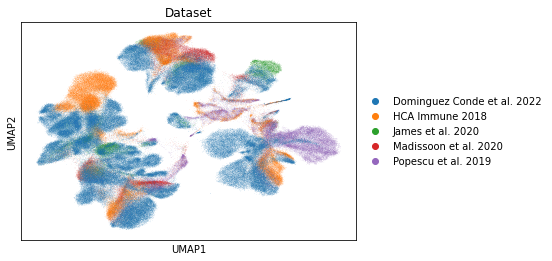

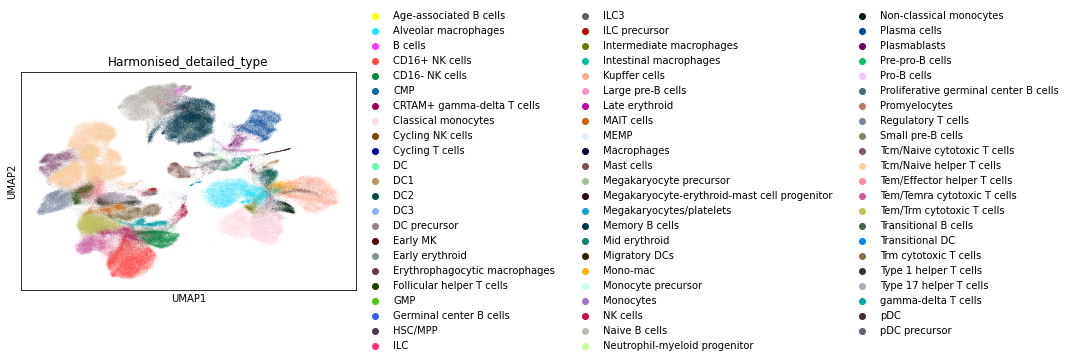

In [5]:
sc.pl.umap(adata, color = 'Dataset')
sc.pl.umap(adata, color = 'Harmonised_detailed_type')

## Scanorama

In [8]:
adata = adata_initial.copy()
del adata.raw
del adata.layers
new_index = adata.obs.sort_values('Dataset').index
adata = adata[new_index].copy()

In [9]:
t_start = time.time()
sc.external.pp.scanorama_integrate(adata, 'Dataset')
sc.pp.neighbors(adata, use_rep="X_scanorama")
t_end = time.time()
sc.tl.umap(adata)
print(f"Time elapsed: {t_end - t_start} seconds")

[[0.         0.06319479 0.40678715 0.18185665 0.0461403 ]
 [0.         0.         0.05096386 0.19494843 0.06720586]
 [0.         0.         0.         0.19538153 0.01040161]
 [0.         0.         0.         0.         0.15792118]
 [0.         0.         0.         0.         0.        ]]
Processing datasets Dominguez Conde et al. 2022 <=> James et al. 2020
Processing datasets James et al. 2020 <=> Madissoon et al. 2020
Processing datasets HCA Immune 2018 <=> Madissoon et al. 2020
Processing datasets Dominguez Conde et al. 2022 <=> Madissoon et al. 2020


Processing datasets Madissoon et al. 2020 <=> Popescu et al. 2019


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Time elapsed: 690.2672326564789 seconds


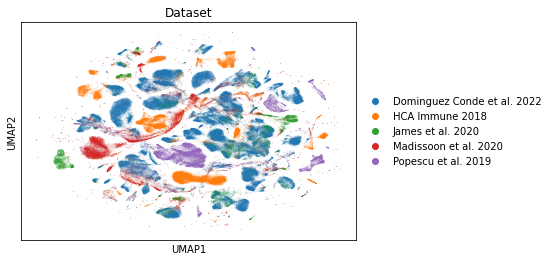

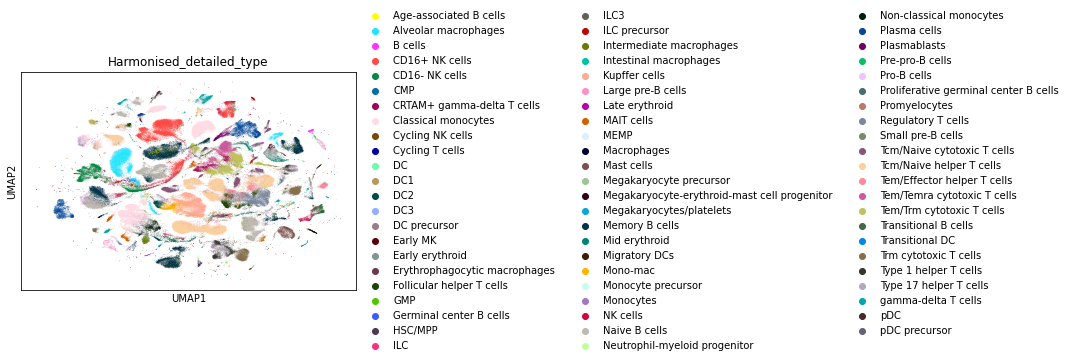

In [10]:
sc.pl.umap(adata, color = 'Dataset')
sc.pl.umap(adata, color = 'Harmonised_detailed_type')

## scVI

In [3]:
adata = adata_initial.copy()
del adata.raw

In [4]:
t_start = time.time()
scvi.model.SCVI.setup_anndata(adata, layer = "counts", batch_key = "Dataset")
vae = scvi.model.SCVI(adata, n_layers = 2, n_latent = 30, gene_likelihood = "nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
t_end = time.time()
sc.tl.umap(adata)
print(f"Time elapsed: {t_end - t_start} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 19/19: 100%|██████████| 19/19 [10:34<00:00, 32.68s/it, loss=631, v_num=1]

`Trainer.fit` stopped: `max_epochs=19` reached.


Epoch 19/19: 100%|██████████| 19/19 [10:34<00:00, 33.42s/it, loss=631, v_num=1]
Time elapsed: 713.4907503128052 seconds


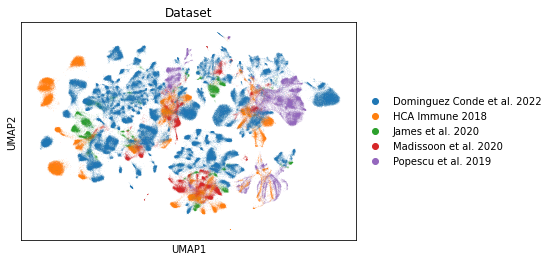

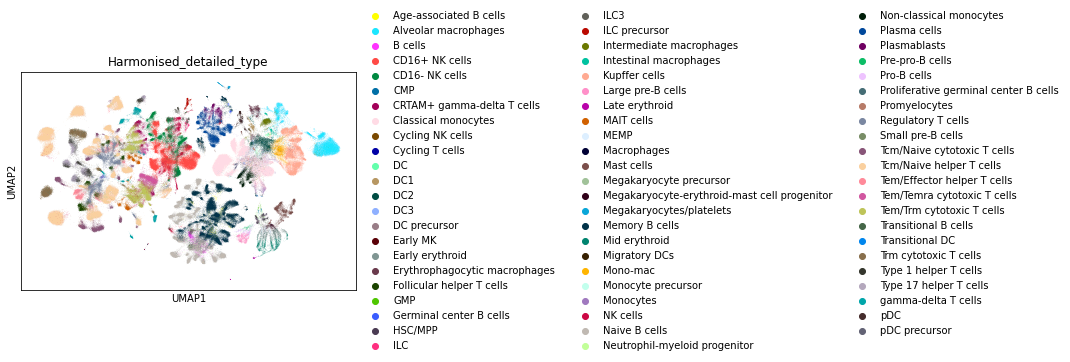

In [5]:
sc.pl.umap(adata, color = 'Dataset')
sc.pl.umap(adata, color = 'Harmonised_detailed_type')

## scANVI

In [3]:
adata = adata_initial.copy()
del adata.raw

`Low_hierarchy` or `High_hierarchy` in the `.obs` is used as the biological key. They are derived from the cell type harmonisation process. Here we use `High_hierarchy` as an example.

In [4]:
t_start = time.time()
scvi.model.SCVI.setup_anndata(adata, layer = "counts", batch_key = "Dataset")
vae = scvi.model.SCVI(adata, n_layers = 2, n_latent = 30, gene_likelihood = "nb")
vae.train()
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = adata, labels_key = 'High_hierarchy', unlabeled_category = "UNASSIGNED")
lvae.train(max_epochs = 20, n_samples_per_label = 100)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)
sc.pp.neighbors(adata, use_rep="X_scANVI")
t_end = time.time()
sc.tl.umap(adata)
print(f"Time elapsed: {t_end - t_start} seconds")

Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 19/19: 100%|██████████| 19/19 [10:15<00:00, 32.17s/it, loss=631, v_num=1]

`Trainer.fit` stopped: `max_epochs=19` reached.


Epoch 19/19: 100%|██████████| 19/19 [10:15<00:00, 32.38s/it, loss=631, v_num=1]
INFO     Training for 20 epochs.                                                             


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [26:50<00:00, 81.05s/it, loss=787, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [26:50<00:00, 80.54s/it, loss=787, v_num=1]
Time elapsed: 2283.1201210021973 seconds


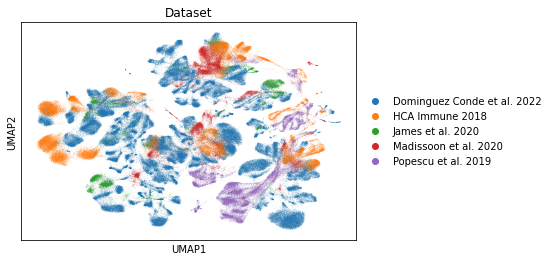

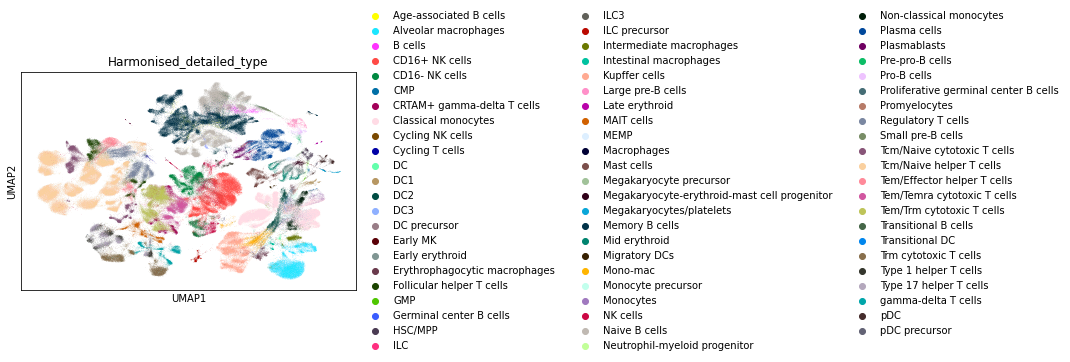

In [5]:
sc.pl.umap(adata, color = 'Dataset')
sc.pl.umap(adata, color = 'Harmonised_detailed_type')

## scGen

In [3]:
adata = adata_initial.copy()
adata = adata.raw.to_adata()

In [4]:
t_start = time.time()
scgen.SCGEN.setup_anndata(adata, batch_key = "Dataset", labels_key = 'High_hierarchy')
model = scgen.SCGEN(adata)
model.train()
adata.obsm["X_scgen"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scgen")
t_end = time.time()
sc.tl.umap(adata)
print(f"Time elapsed: {t_end - t_start} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 19/19: 100%|██████████| 19/19 [09:57<00:00, 30.90s/it, loss=78.5, v_num=1]

`Trainer.fit` stopped: `max_epochs=19` reached.


Epoch 19/19: 100%|██████████| 19/19 [09:57<00:00, 31.44s/it, loss=78.5, v_num=1]
Time elapsed: 655.612560749054 seconds


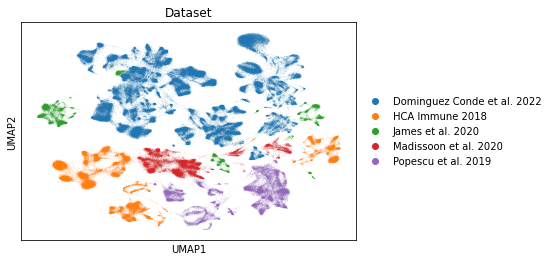

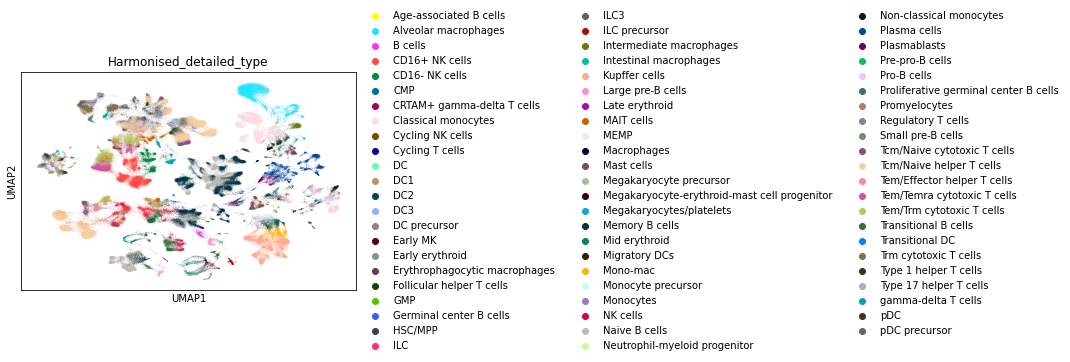

In [5]:
sc.pl.umap(adata, color = 'Dataset')
sc.pl.umap(adata, color = 'Harmonised_detailed_type')

## CellTypist

In [3]:
adata = adata_initial.copy()
del adata.raw
del adata.layers

In [4]:
t_start = time.time()
celltypist.integrate(adata, 'Dataset', 'High_hierarchy')
t_end = time.time()
sc.tl.umap(adata)
print(f"Time elapsed: {t_end - t_start} seconds")

👀 `use_rep` is not specified, will use `'X_pca'` as the search space


Time elapsed: 80.06831860542297 seconds


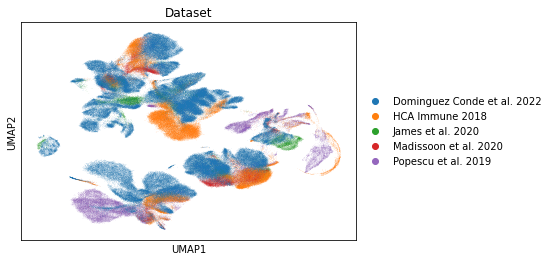

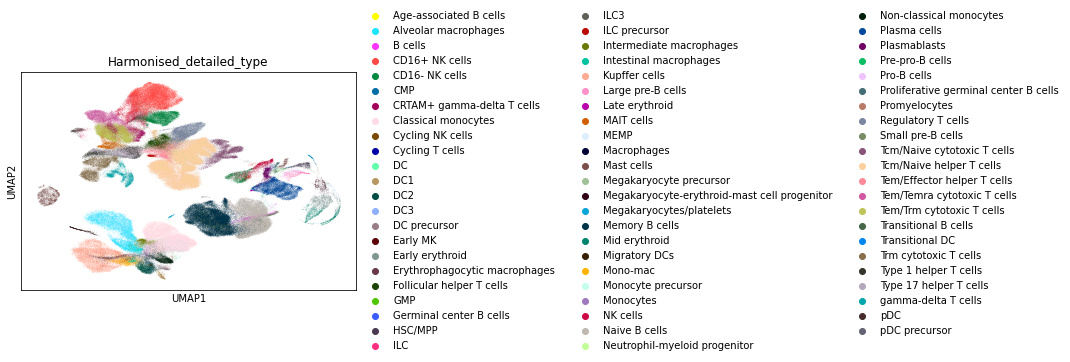

In [5]:
sc.pl.umap(adata, color = 'Dataset')
sc.pl.umap(adata, color = 'Harmonised_detailed_type')